## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
%matplotlib inline
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 1.5)
sns.set_style('ticks')
sns.set()

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Pickle
import joblib

# Data pre-processing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

# Import under sampling module from imbalanced learn
from imblearn.under_sampling import RandomUnderSampler
# Import SMOTE from imbalanced learn
from imblearn.over_sampling import SMOTE

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

In [2]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load Cleaned  Data

In [3]:
df = pd.read_csv('../data/cleaned_data_2014_to_2017.csv')
df.head()

,Record,Location,X,Y,Date,Time,Environment,Road_Surface,Traffic_Control,Collision_Location,Light,Collision_Classification,Impact_type,Year,Month,Week_day
0,1,RIDEAU ST @ WALLER ST,368282.69327,5.032275e+06,2014-02-21,06:07:00,02 - Rain,02 - Wet,01 - Traffic signal,03 - At intersection,07 - Dark,01 - Fatal injury,07 - SMV other,2014,February,Friday
1,2,HINES RD btwn INNOVATION DR & SOLANDT RD,350172.08885,5.022740e+06,2014-08-02,13:55:00,01 - Clear,01 - Dry,10 - No control,04 - At/near private drive,01 - Daylight,01 - Fatal injury,02 - Angle,2014,August,Saturday
2,4,MONTREAL RD @ BATHGATE DR/BURMA RD,373224.24847,5.034518e+06,2014-07-29,16:31:00,01 - Clear,01 - Dry,01 - Traffic signal,03 - At intersection,01 - Daylight,01 - Fatal injury,05 - Turning movement,2014,July,Tuesday
3,5,RICHMOND RD btwn FALLOWFIELD RD & RUSHMORE RD,358156.20481,5.012570e+06,2014-08-05,20:05:00,01 - Clear,01 - Dry,10 - No control,01 - Non intersection,05 - Dusk,01 - Fatal injury,07 - SMV other,2014,August,Tuesday
4,6,PARKDALE AVE btwn RUSKIN ST & INGLEWOOD PL,365558.54334,5.028338e+06,2014-04-19,10:22:00,01 - Clear,01 - Dry,10 - No control,01 - Non intersection,01 - Daylight,01 - Fatal injury,06 - SMV unattended vehicle,2014,April,Saturday


In [4]:
# Data Shape
df.shape

(57768, 16)

In [5]:
# Datatypes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57768 entries, 0 to 57767
Data columns (total 16 columns):
Record                      57768 non-null int64
Location                    57768 non-null object
X                           57768 non-null float64
Y                           57768 non-null float64
Date                        57768 non-null object
Time                        57768 non-null object
Environment                 57767 non-null object
Road_Surface                57768 non-null object
Traffic_Control             57733 non-null object
Collision_Location          57762 non-null object
Light                       57766 non-null object
Collision_Classification    57768 non-null object
Impact_type                 57768 non-null object
Year                        57768 non-null int64
Month                       57768 non-null object
Week_day                    57768 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 7.1+ MB


Observation

- There are 3 numerical  and 12 categorical attributes in the dataset

-  Traffic_Control, Collision_Location, and Light have missing values. We will come back to the missing values later in data preprocessing.


In [6]:
# Drop speified attributes 
df = df.drop(['Time', 'Date', 'Record','Location'], axis = 1)

In [7]:
# Attrinute names
df.columns

Index(['X', 'Y', 'Environment', 'Road_Surface', 'Traffic_Control',
       'Collision_Location', 'Light', 'Collision_Classification',
       'Impact_type', 'Year', 'Month', 'Week_day'],
      dtype='object')

## Class Distribution

In [8]:
df.Collision_Classification.value_counts()

03 - P.D. only           46790
02 - Non-fatal injury    10885
01 - Fatal injury           93
Name: Collision_Classification, dtype: int64

The P.D only and the Non-fatal injury classes can be combined to form a general Non-fatal injury class reducing the dataset to a binary class problem. We will do this is during the data preprocessing. For now we will use the three classes in the exploratory data analysis (EDA)

In [9]:
df.Collision_Classification = df.Collision_Classification.replace('03 - P.D. only', '02 - Non-fatal injury').\
replace('02 - Non-fatal injury', 'Non-fatal injury')

In [10]:
df.Collision_Classification = df.Collision_Classification.replace('01 - Fatal injury', 'Fatal injury')

In [11]:
df.Collision_Classification.value_counts()

Non-fatal injury    57675
Fatal injury           93
Name: Collision_Classification, dtype: int64

In [12]:
#df.groupby(['Collision_Classification', 'Environment'])['Collision_Classification'].aggregate('count').unstack()

##  Feature Matrix  and Class Variable

In [13]:
X, y = df.drop(['Collision_Classification'], axis = 1), df['Collision_Classification']

## Create a Test Set

In [14]:
# Create 70% training set and 30% test set using stratify sampling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 42, stratify = y)

In [15]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print("**************************************************")
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 Non-fatal injury    99.839256
Fatal injury         0.160744
Name: Collision_Classification, dtype: float64
**************************************************
Test set class distribution:
 Non-fatal injury    99.83844
Fatal injury         0.16156
Name: Collision_Classification, dtype: float64


In [16]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (40437, 11) (40437,)
Test set size: (17331, 11) (17331,)


## Impute Missing Value

As we saw above, there are some attributes with missing values. We will now impute the missing values in those attributes for a better performance

In [17]:
# Instantiate the imputer class
imputer = DataFrameImputer()

# Fit transform the training set
X_train_imputed = imputer.fit_transform(X_train)

# Only transform the test set
X_test_imputed = imputer.fit_transform(X_test)

It is good to cross-check whether the missing values have been imputed

In [18]:
# Cross-check for missing values
print(X_train_imputed.isnull().sum())
print('***************************')
print(X_test_imputed.isnull().sum())

X                     0
Y                     0
Environment           0
Road_Surface          0
Traffic_Control       0
Collision_Location    0
Light                 0
Impact_type           0
Year                  0
Month                 0
Week_day              0
dtype: int64
***************************
X                     0
Y                     0
Environment           0
Road_Surface          0
Traffic_Control       0
Collision_Location    0
Light                 0
Impact_type           0
Year                  0
Month                 0
Week_day              0
dtype: int64


##  Feature Scaling and Handling Categorical Attributes

As we saw above, most of the attributes are categorical, and they need to be converted to numeric before applying the machine learning algorithms. We also need to scale the numerical attributes for a better performance

In [19]:
# Numerical attributes list
num_list = list(X.select_dtypes('number'))

# Categorical attributes list
cat_list = list(X.select_dtypes('O'))

# Standardize the numerical attributes
num_attribs = [([num], StandardScaler()) for num in num_list]

# Binarize the categorical attributes
cat_attribs = [([cat], LabelBinarizer()) for cat in cat_list]

# Build a pipeline for the data pre-processing
mapper =  DataFrameMapper(num_attribs + cat_attribs)

# Fit transform the training set
X_train_prepared = mapper.fit_transform(X_train_imputed)

# Only transform the test set
X_test_prepared = mapper.transform(X_test_imputed)

In [20]:
print('Training set size after pre-processing:', X_train_prepared.shape)
print('Test set size after pre-processing:', X_test_prepared.shape)

Training set size after pre-processing: (40437, 78)
Test set size after pre-processing: (17331, 78)


## Dimensionality Reduction

In [21]:
# PCA with unscaled training data
pca = PCA(n_components = 2)
X_train_reduced_pca = pca.fit_transform(X_train_prepared)

In [22]:
# Put in dataframe
X_train_reduced_pca = pd.DataFrame(data = X_train_reduced_pca)
X_train_reduced_pca.columns = ['PC1', 'PC2']
X_train_reduced_pca['Class'] = y_train.reset_index(drop = True)
X_train_reduced_pca.head()

,PC1,PC2,Class
0,-0.805622,-0.327168,Non-fatal injury
1,-1.729044,0.376455,Non-fatal injury
2,1.470190,-0.349696,Non-fatal injury
3,-1.008005,1.332137,Non-fatal injury
4,-0.658819,-1.287360,Non-fatal injury


In [40]:
# Pickle pca dataframe
X_train_reduced_pca.to_pickle('../data/pca.pkl') 

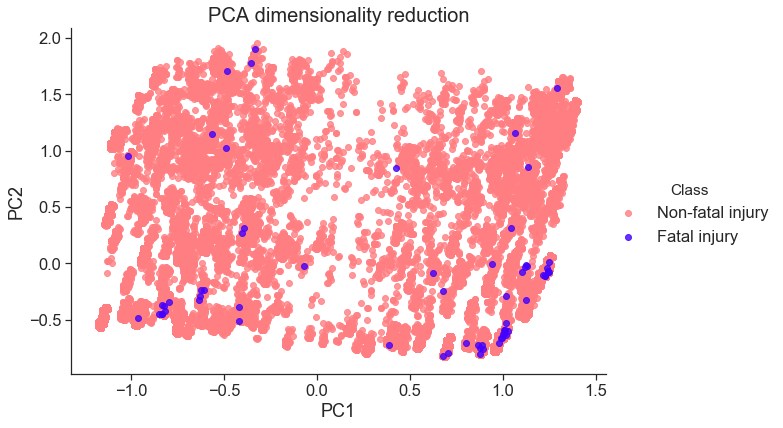

In [41]:
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Load file
X_train_reduced_pca = pd.read_pickle('../data/pca.pkl') 
# Plot
sns.lmplot(data = X_train_reduced_pca, x = 'PC1', y = 'PC2', hue = 'Class', 
           fit_reg = False, height= 6, aspect=1.5, palette = 'gnuplot2_r')
plt.title('PCA dimensionality reduction', fontsize = 20)
plt.savefig('../image/pca.png')

##  Encode the Class Variable

In [23]:
# Dictionary mapping
map_target = {'Fatal injury': 1, 'Non-fatal injury': 0}

# Map to discrete numbers
y_train_label = y_train.map(map_target)
y_test_label = y_test.map(map_target)

## Model Selection by Cross-Validation

The results below show that 

-  The overrall accuracy is not good metrics for the imbalanced dataset as they are biased towards the majority class.

- All the models predicted only the majority class and the recall and precision of the minority (positive) class are all zero

## 1. Logistic Regression

In [29]:
log_clf = LogisticRegression()
model_selection_cv(log_clf, X_train_prepared, y_train_label, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.998393 (0.000000)
AUROC: 0.817091
AUPRC: 0.007738
Predicted classes: [0]
Confusion matrix:
 [[40372     0]
 [   65     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40372
           1       0.00      0.00      0.00        65

    accuracy                           1.00     40437
   macro avg       0.50      0.50      0.50     40437
weighted avg       1.00      1.00      1.00     40437

****************************************************************************


## 2. Random Forest

In [25]:
rf_clf = RandomForestClassifier(random_state = 42)
model_selection_cv(rf_clf, X_train_prepared, y_train_label, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.998393 (0.000000)
AUROC: 0.509337
AUPRC: 0.001684
Predicted classes: [0]
Confusion matrix:
 [[40372     0]
 [   65     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40372
           1       0.00      0.00      0.00        65

    accuracy                           1.00     40437
   macro avg       0.50      0.50      0.50     40437
weighted avg       1.00      1.00      1.00     40437

****************************************************************************


## 3. XGBoost

In [26]:
xgb_clf = xgb.XGBClassifier()
model_selection_cv(xgb_clf, X_train_prepared, y_train_label, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.998393 (0.000000)
AUROC: 0.794233
AUPRC: 0.012387
Predicted classes: [0]
Confusion matrix:
 [[40372     0]
 [   65     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40372
           1       0.00      0.00      0.00        65

    accuracy                           1.00     40437
   macro avg       0.50      0.50      0.50     40437
weighted avg       1.00      1.00      1.00     40437

****************************************************************************


## Cost Sensitive Method and  Hyperparameter Tuning 

We will optimize the **Recall** by tuning  the hyperparameters of all the models

In [27]:
 # Cost ratio of the negative class to the positive  class
neg = y_train_label == 0
pos = y_train_label == 1
cost_ratio = np.sum(neg)/np.sum(pos)
cost_ratio

621.1076923076923

## 1 . Logistic Regression

In [30]:
# Range of hyperparameters
param_grid = {'C': [2**x for x in range(-3,7,2)], 
             'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]}
                             
# Grid search
gsearch_log = GridSearchCV(log_clf, param_grid, cv = 5,
                           scoring = 'recall',verbose =1, n_jobs = -1)
                                
# Fit the  training set
gsearch_log.fit(X_train_prepared, y_train_label)

print('Grid search best score:', gsearch_log.best_score_)
print('Grid search best parameters:', gsearch_log.best_params_)    

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.2min finished


Grid search best score: 0.6000045655064574
Grid search best parameters: {'C': 0.125, 'class_weight': 'balanced'}


## 2. Random Forest

In [35]:
# Range of hyperparameters
params = {'max_features': [1, 0.5, 'sqrt', 'log2'],
          'min_samples_leaf':[1,5,10,30], 
         'class_weight': ['balanced', 'balanced_subsample',{0:1, 1:3},{0:1, 1:cost_ratio}]}
               
# Randomized Search
rf_clf = RandomForestClassifier(n_estimators = 200, random_state = 42)
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params,scoring = 'recall',
                                cv = 5,n_jobs = -1, random_state = 42, verbose = 1)
                                
# Fit the  training set                                                                                          
rsearch_rf.fit(X_train_prepared, y_train_label)

# Print score
print('Best Recall Score:', rsearch_rf.best_score_) 
print('Best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.1min finished


Best Recall Score: 0.0
Best hyperparameters: {'min_samples_leaf': 1, 'max_features': 0.5, 'class_weight': {0: 1, 1: 621.1076923076923}}


## 3. XGBoost

In [38]:
# Range of hyperparameters
params = {'max_depth': range(3,10,2), 'min_child_weight': range(1,6,2),
         'subsample':[i/10 for i in range(5,9)],'colsample_bytree': [i/10 for i in range(5,9)]}

# Randomized Search
xgb_clf =  xgb.XGBClassifier(n_estimators = 500, objective = 'binary:logistic', 
                             scale_pos_weight = cost_ratio, learning_rate = 0.1) 
rsearch_xgb = RandomizedSearchCV(estimator = xgb_clf, param_distributions = params, 
                                  scoring = 'recall', cv = 5, n_jobs = -1, 
                                  random_state = 42, verbose = 1)  
# Fit the  training set                                                         
rsearch_xgb.fit(X_train_prepared, y_train_label)

# Print score
print('Best Recall Score:', rsearch_xgb.best_score_) 
print('Best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 25.1min finished


Best Recall Score: 0.06153922245620443
Best hyperparameters: {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 3, 'colsample_bytree': 0.5}


# Prediction on the Test Set
Let's make prediction on the test set using the best estimators from the randomized search

## 1. Logistic Regression

In [42]:
best_lr = gsearch_log.best_estimator_
Test_Prediction(best_lr, X_train_prepared, y_train_label, X_test_prepared, y_test_label)

****************************************************************************
Test accuracy:  0.803589
AUROC: 0.755804
AUPRC: 0.006872
Predicted classes: [0 1]
Confusion matrix:
 [[13913  3390]
 [   14    14]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89     17303
           1       0.00      0.50      0.01        28

    accuracy                           0.80     17331
   macro avg       0.50      0.65      0.45     17331
weighted avg       1.00      0.80      0.89     17331

****************************************************************************


## 2. Random Forest

In [43]:
best_rf = rsearch_rf.best_estimator_
Test_Prediction(best_rf, X_train_prepared, y_train_label, X_test_prepared, y_test_label)

****************************************************************************
Test accuracy:  0.998384
AUROC: 0.608529
AUPRC: 0.005424
Predicted classes: [0]
Confusion matrix:
 [[17303     0]
 [   28     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17303
           1       0.00      0.00      0.00        28

    accuracy                           1.00     17331
   macro avg       0.50      0.50      0.50     17331
weighted avg       1.00      1.00      1.00     17331

****************************************************************************


## 3. XGBoost

In [44]:
best_xgb = rsearch_xgb.best_estimator_
Test_Prediction(best_xgb, X_train_prepared, y_train_label, X_test_prepared, y_test_label)

****************************************************************************
Test accuracy:  0.983325
AUROC: 0.692240
AUPRC: 0.006902
Predicted classes: [0 1]
Confusion matrix:
 [[17038   265]
 [   24     4]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     17303
           1       0.01      0.14      0.03        28

    accuracy                           0.98     17331
   macro avg       0.51      0.56      0.51     17331
weighted avg       1.00      0.98      0.99     17331

****************************************************************************


# ROC  and PR Curves on the  Test set

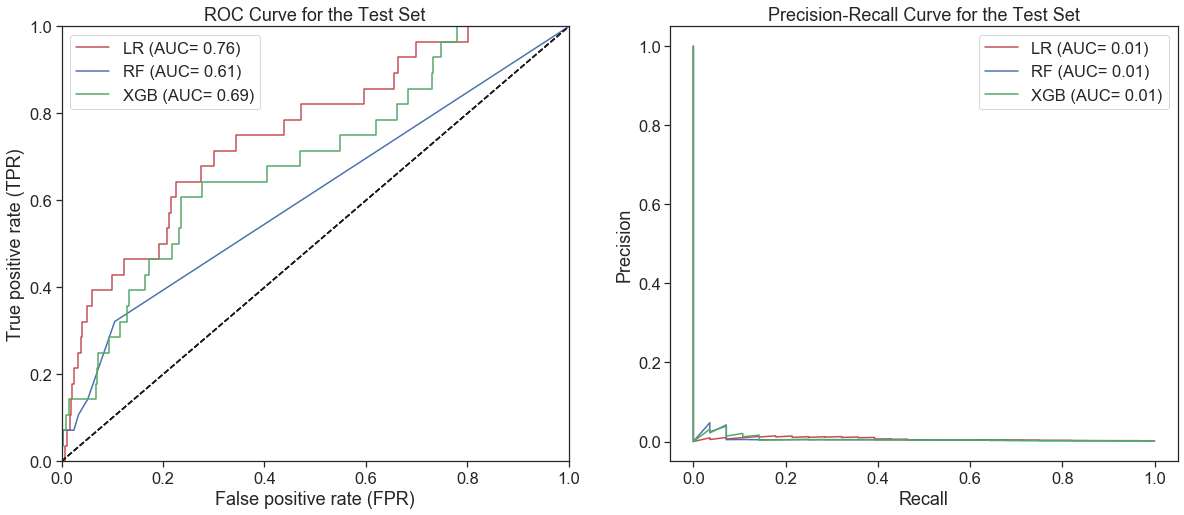

In [46]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Plot ROC and PR Curves for LR
Plot_ROC_Curve_and_PRC(best_lr, X_train_prepared, y_train_label, X_test_prepared, y_test_label,
                     color= 'r', label = 'LR (AUC= %0.2f)')

# Plot ROC and PR Curves for RF
Plot_ROC_Curve_and_PRC(best_rf, X_train_prepared, y_train_label, X_test_prepared, y_test_label,
                        color= 'b', label = 'RF (AUC= %0.2f)')

# Plot ROC and PR Curves for XGB
Plot_ROC_Curve_and_PRC(best_xgb, X_train_prepared, y_train_label, X_test_prepared, y_test_label,
                        color= 'g', label = 'XGB (AUC= %0.2f)')